In [25]:
from stacked_mnist import *
from verification_net import VerificationNet
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from autoencoder import Autoencoder
from util import *
import os

In [26]:
# GLOBALS
BATCH_SIZE = 1024
EPOCHS = 40
NUM_CHANNELS = 1

In [27]:
_train_data = StackedMNISTData(mode=DataMode.MONO_BINARY_MISSING)
_test_data = StackedMNISTData(mode=DataMode.MONO_BINARY_COMPLETE)

train_dataset = _train_data.get_full_data_set(training=True)
test_dataset = _test_data.get_full_data_set(training=False)

In [28]:
class StackedMnistDataset(Dataset):
    def __init__(self, data):
        self.X = torch.from_numpy(data[0]).float()
        self.y = torch.from_numpy(data[1]).float()
        # turn them into long tensors
        self.y = self.y.long()
        

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [29]:
stacked_mnist_train = StackedMnistDataset(train_dataset)
stacked_mnist_test = StackedMnistDataset(test_dataset)

train_loader = DataLoader(stacked_mnist_train, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(stacked_mnist_test, batch_size=1, shuffle=False)

In [30]:
for x, y in train_loader:
    # reshape to (batch_size, num_channels, height, width)
    x = x.reshape(-1, 1, 28, 28)
    print(x.shape)
    print(y.shape)
    break

torch.Size([1024, 1, 28, 28])
torch.Size([1024])


In [32]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")
# model = Autoencoder()

try:
    model = torch.load("./models/mono_autoencoder")
    model.to(device)
    print("Loaded model from file")

except:
    print("couldnt load")

device: cuda
Loaded model from file


In [21]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")
model = Autoencoder()
criterion = nn.BCELoss()
# criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

model.to(device)

device: cuda


Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=64, out_features=32, bias=True)
    (11): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0.2)
    (13): Linear(in_features=32, out_features=16, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=32

In [22]:
def train(epochs = EPOCHS, force_retrain=False):

    # try to load the model if it exists and force_retrain is False
    if not force_retrain:
        try:
            checkpoint = torch.load("./models/anom_autoencoder.pth")
            model.load_state_dict(checkpoint["model_state_dict"])
            optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
            start_epoch = checkpoint["epoch"] + 1
            print("Loaded checkpoint from epoch", start_epoch)
        except:
            start_epoch = 0
            print("Starting from scratch")
    else:
        start_epoch = 0
        print("Starting from scratch (forced retrain)")

    # train the model
    outputs = []
    model.train()
    for epoch in range(start_epoch, epochs):
        for im, _ in train_loader:
            num_channels = im.shape[-1]
            im = im.reshape(-1, num_channels, 28, 28)
            im = im.to(device)
            # ===================forward=====================
            output = model(im)
            output = output.squeeze().reshape(-1, num_channels, 28, 28)
            loss = criterion(output, im)
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # ===================log========================
        print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, epochs, loss.item()))
        outputs.append((epoch, im, output))

    # save the model
    if outputs:
        checkpoint = {
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
        }
        os.makedirs("./models", exist_ok=True)
        torch.save(checkpoint, "./models/anom_autoencoder.pth")

    return outputs

In [23]:
EPOCHS = 100
train_outputs = train(epochs=EPOCHS, force_retrain=False)

Starting from scratch (forced retrain)
epoch [1/100], loss:0.3037
epoch [2/100], loss:0.2004
epoch [3/100], loss:0.1497
epoch [4/100], loss:0.1225
epoch [5/100], loss:0.1064
epoch [6/100], loss:0.0960
epoch [7/100], loss:0.0920
epoch [8/100], loss:0.0850
epoch [9/100], loss:0.0819
epoch [10/100], loss:0.0787
epoch [11/100], loss:0.0787
epoch [12/100], loss:0.0747
epoch [13/100], loss:0.0756
epoch [14/100], loss:0.0739
epoch [15/100], loss:0.0703
epoch [16/100], loss:0.0698
epoch [17/100], loss:0.0671
epoch [18/100], loss:0.0671
epoch [19/100], loss:0.0662
epoch [20/100], loss:0.0660
epoch [21/100], loss:0.0656
epoch [22/100], loss:0.0659
epoch [23/100], loss:0.0636
epoch [24/100], loss:0.0637
epoch [25/100], loss:0.0638
epoch [26/100], loss:0.0632
epoch [27/100], loss:0.0630
epoch [28/100], loss:0.0637
epoch [29/100], loss:0.0633
epoch [30/100], loss:0.0631
epoch [31/100], loss:0.0617
epoch [32/100], loss:0.0603
epoch [33/100], loss:0.0590
epoch [34/100], loss:0.0609
epoch [35/100], lo

In [24]:
torch.save(model, "./models/mono_autoencoder")

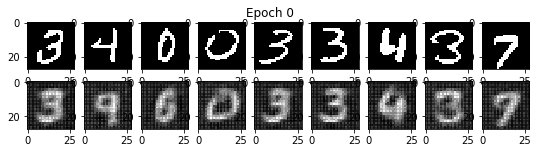

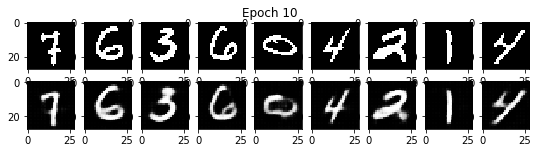

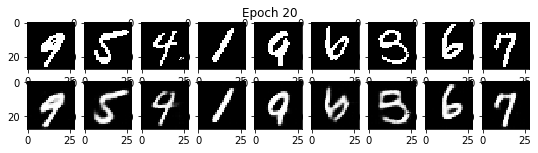

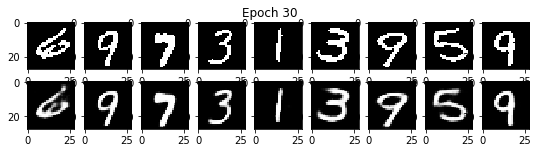

In [33]:
if train_outputs:
    # ensure 10 iterations
    desired_iterations = 10
    num_train_outputs = len(train_outputs)
    step = max(num_train_outputs // desired_iterations, 1)
    
    for k in range(0, EPOCHS, step):
        plt.figure(figsize=(9, 2))
        plt.gray()

        imgs = train_outputs[k][1].reshape(-1, 28, 28, 1).detach().cpu().numpy()
        recon = train_outputs[k][2].reshape(-1, 28, 28, 1).detach().cpu().numpy()

        for i, item in enumerate(imgs):
            if i >= 9:
                break
            plt.subplot(2, 9, i + 1)
            plt.imshow(item.squeeze())

        for i, item in enumerate(recon):
            if i >= 9:
                break
            plt.subplot(2, 9, 9 + i + 1)
            plt.imshow(item.squeeze())

        plt.suptitle(f"Epoch {k}")

Text(0, 0.5, 'Count')

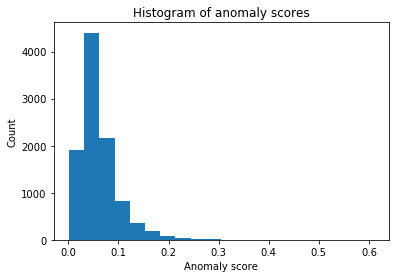

In [34]:
# do anomaly detection
model.eval()
anom_scores = []
for i, data in enumerate(test_loader):
    img, _ = data
    num_channels = img.shape[-1]
    img = img.reshape(-1, num_channels, 28, 28)
    img = img.to(device)
    output = model(img)
    output = output.squeeze().reshape(-1, num_channels, 28, 28)
    loss = criterion(output, img)
    anom_scores.append(loss.item())

# plot the anomaly scores
plt.figure()
plt.hist(anom_scores, bins=20)
plt.title("Histogram of anomaly scores")
plt.xlabel("Anomaly score")
plt.ylabel("Count")

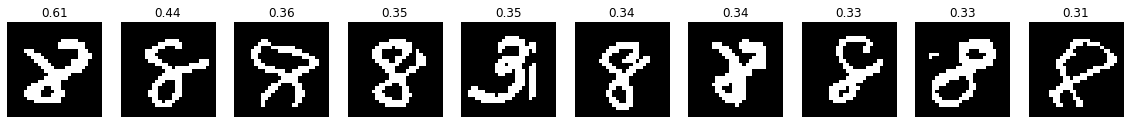

In [35]:
max_error_indexes = np.argsort(anom_scores)[::-1]
worst_10 = max_error_indexes[:10]

# plot the worst 10
plt.figure(figsize=(20, 4))
for i, index in enumerate(worst_10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(test_dataset[0][index].reshape(28, 28), cmap="gray")
    plt.title(f"{anom_scores[index]:.2f}")
    plt.axis("off")
